# Single-cell and spatial transcriptomics data analysis with squidpy in python
##### Graduate Group in Bioinformatics, University of Assuit, computer science
##### 4/7/2022

### Table of Contents
<ul>
<li><a href="#lp">1 Load packages</a></li>
<li><a href="#ao">2 Anndata object</a><ul>
  <li><a href="#lvd">2.1 load 10X Genomics Visium dataset into Anndata</a></li>
<li><a href="#eao">2.2 Explore the Anndata object</a><ul>
    <li><a href="#dao"> 2.2.1 Dimension of Anndata object </a></li>
    <li><a href="#names"> 2.2.2 Feature and observation names </a></li>
    <li><a href="#olm">2.2.3 observation-level metadata </a></li>
    <li><a href="#flm">2.2.4 object with feature-level metadata </a></li></ul>
    </ul></li>
<li><a href="#ais">3 Analysis pipeline in squidpy</a></li><ul>
    <li><a href="#pd">3.1 Preprocess data</a></li>
    <ul>
        <li><a href="#qc"> 3.1.1 Quality control</a></li>
        <li><a href="#n">3.1.2 Normalization </a></li>
    </ul>
    <li><a href="#dt"> 3.2 Downstream tasks (dimension reduction, data visualization, cluster annotation, differential expression)</a></li>
    <li><a href="#vsc">3.3 Visualization in spatial coordinates</a></li>
    <li><a href="#ss">3.4 Spatial statistics and graph analysis</a></li><ul>
    <li><a href="#ne">3.4.1 Neighborhood enrichment</a></li>
    <li><a href="#csd">3.4.2 Co-occurrence across spatial dimensions </a></li>
    <li><a href="#lra">3.4.3 Ligand-receptor interaction analysis</a></li>
    </ul>
    <li><a href="#isv">3.5 Identify spatially variable genes</a></li><ul>
    <li><a href="#m">3.5.1 Moran’s I</a></li>
    </ul>
    </ul>
<li><a href="#a">4 Acknowledgements</a></li>


<a id='lp'></a>
# 1 Load Pakages
Besides squidpy, we need to import some useful packages.
<ul>
    <li>scanpy for preprocessing data and single_cells analysis </li>
    <li>anndata to work with Anndata object </li>
    <li>pandas to work with data as dataframe</li>
    <li>matplotlib for data visualization </li>
    <li>seaborn for more interactive data visualization </li>
</ul>

In [1]:
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import squidpy as sq
import anndata as ad
import numpy as np
from bioinfokit import analys, visuz

<a id='ao'></a>
# 2 Anndata object

We first load one spatial transcriptomics dataset into Anndata, and then explore the Anndata object a bit for spatial data storage and manipulation. One 10X Genomics Visium dataset will be analyzed with Squidpy in our project 

<a id='lvd'></a>
## 2.1 load 10X Genomics Visium dataset into Anndata

A spatial gene expression dataset of mouse brain serial section 2 (Sagittal-Posterior) collected by Space Ranger 1.1.0. will be analyzed throughout the tutorial. Both the gene expression matrix and spatial imaging data are necessary for the computational analysis.

For illustration purposes,we load data from 10x Genomics, by sc.datasets.visium_sge()function that take sample_id and return anndata object that contain data
our sample_id = V1_Mouse_Brain_Sagittal_Posterior_Section_2


The data files we will be using include:
<ul>
    <li>a (filtered) feature / cell matrix HDF5 file (.h5)</li>
    <li>a spatial imaging data</li>
</ul>

In [2]:
#read data
adata = sc.datasets.visium_sge(sample_id="V1_Mouse_Brain_Sagittal_Posterior_Section_2")

adata

C:\Users\AL-FAJR\anaconda3\lib\site-packages\anndata\_core\anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 3289 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

<a id='eao'></a>
## 2.2 Explore the Anndata object 

<p>A Anndata object serves as a container that contains both data (like the count matrix) ,spatial images and analysis (like dimension reduction or clustering results) for a single-cell dataset.</p>

<a id='dao'></a>
### 2.2.1 Dimension of Anndata object

<p>Extract the dimension of the anadata object using shape, shape[0] for nraws, shape[1] for ncols</p>



In [3]:
adata.shape  # the number of features (genes) by cells (spots)

(3289, 32285)

In [4]:
print("the number of cells (nrows)", adata.shape[0]) #the number of cells (nrows)
print("the number of features(genes)(ncols)",adata.shape[1]) #the number of features(genes)(ncols)

the number of cells (nrows) 3289
the number of features(genes)(ncols) 32285


<a id='names'></a>
### 2.2.2 Feature and observation names 

Extract the feature and observation names using . obs.names & var.names 



In [5]:
adata.obs_names[0:5] #names of observations (cells)

Index(['AAACAAGTATCTCCCA-1', 'AAACACCAATAACTGC-1', 'AAACAGCTTTCAGAAG-1',
       'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1'],
      dtype='object')

In [6]:
adata.var_names[0:5] #names of features (genes)

Index(['Xkr4', 'Gm1992', 'Gm19938', 'Gm37381', 'Rp1'], dtype='object')

<a id='olm'></a>
### 2.2.3 observation-level metadata

<p>observation-level metadata is stored as a data.frame, where each row correspond to one observation (e.g. cell or spot) and each column correspond to one observation-level metadata field. It can be accessed via (adata.obs). Row names in the metadata need to match the raw names of the counts matrix.</p>

In [7]:
type(adata.obs)

pandas.core.frame.DataFrame

In [8]:
df=adata.obs
df.columns ## automatically calculated while creating the Anndata object

Index(['in_tissue', 'array_row', 'array_col'], dtype='object')

In [9]:
df.head()

,in_tissue,array_row,array_col
AAACAAGTATCTCCCA-1,1,50,102
AAACACCAATAACTGC-1,1,59,19
AAACAGCTTTCAGAAG-1,1,43,9
AAACAGGGTCTATATT-1,1,47,13
AAACAGTGTTCCTGGG-1,1,73,43


In [10]:
adata.obs["in_tissue"][0:3]

AAACAAGTATCTCCCA-1    1
AAACACCAATAACTGC-1    1
AAACAGCTTTCAGAAG-1    1
Name: in_tissue, dtype: int64

<a id='olf'></a>
### 2.2.3 object with features-level metadata

<p>feature-level metadata is stored as a data.frame, where each row correspond to one feature (e.g. gene ) and each column correspond to one feature-level metadata field. It can be accessed via (var.obs). Row names in the metadata need to match the column names of the counts matrix.</p>

In [11]:
type(adata.var)

pandas.core.frame.DataFrame

In [12]:
df=adata.var
df.columns ## automatically calculated while creating the Anndata object

Index(['gene_ids', 'feature_types', 'genome'], dtype='object')

In [13]:
df.head()

,gene_ids,feature_types,genome
Xkr4,ENSMUSG00000051951,Gene Expression,mm10
Gm1992,ENSMUSG00000089699,Gene Expression,mm10
Gm19938,ENSMUSG00000102331,Gene Expression,mm10
Gm37381,ENSMUSG00000102343,Gene Expression,mm10
Rp1,ENSMUSG00000025900,Gene Expression,mm10


In [14]:
adata.var["gene_ids"][0:5]

Xkr4       ENSMUSG00000051951
Gm1992     ENSMUSG00000089699
Gm19938    ENSMUSG00000102331
Gm37381    ENSMUSG00000102343
Rp1        ENSMUSG00000025900
Name: gene_ids, dtype: object

<p> AnnData is specifically designed for matrix-like data. By this we mean that we have  observations (cells), each of which can be represented as -dimensional vectors, where each dimension corresponds to a variable or feature (genes). Both the rows and columns of this  matrix are special in the sense that they are indexed </p>

In [15]:
adata

AnnData object with n_obs × n_vars = 3289 × 32285
    obs: 'in_tissue', 'array_row', 'array_col'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spatial'

In [16]:
adata.X

<3289x32285 sparse matrix of type '<class 'numpy.float32'>'
	with 14939549 stored elements in Compressed Sparse Row format>

In [17]:
df=adata.to_df()
df.iloc[0:3, 4:10]

,Rp1,Sox17,Gm37587,Gm37323,Mrpl15,Lypla1
AAACAAGTATCTCCCA-1,0.0,0.0,0.0,0.0,1.0,1.0
AAACACCAATAACTGC-1,0.0,0.0,0.0,0.0,0.0,0.0
AAACAGCTTTCAGAAG-1,0.0,0.0,0.0,0.0,1.0,0.0


<a id='ais'></a>
# 3 Analysis pipeline in squidpy

The general steps to perform preprocessing, dimensiona reduction and clustering for spatial transcriptomics data are quite similar to the scanpy workflow analyzing single-cell RNA sequencing data.

<a id='pd'></a>
## 3.1 Preprocess data

A standard preprocessing workflow includes the selection and filtration of cells based on quality control (QC) metrics, data normalization and (optional) scaling, and the detection of highly variable features.



<a id='qc'></a>
### 3.1.1 Quality control

A few common QC metrics include
<ul>
    <li>The number of unique genes detected in each sample (n_genes_by_counts).</li>
    <li>The total number of molecules detected within a sample (total_counts).</li>
    <li>The percentage of reads that map to the mitochondrial genome</li>
</ul>

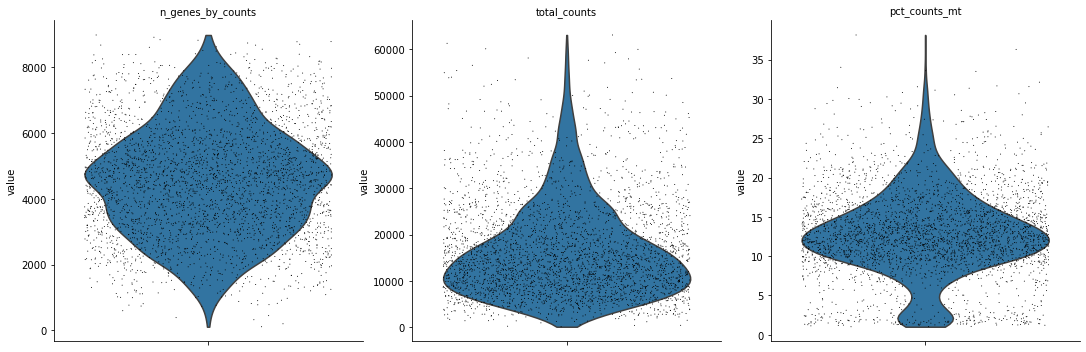

In [18]:
#make names unique
adata.var_names_make_unique()

#add new boolean metadata to var(genes)
#mt ->genes that names start with MT- make it true else false 
adata.var["mt"] = adata.var_names.str.startswith("mt-")

#quality control matrix used to determine total_counts ....
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

#draw a violin plot
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

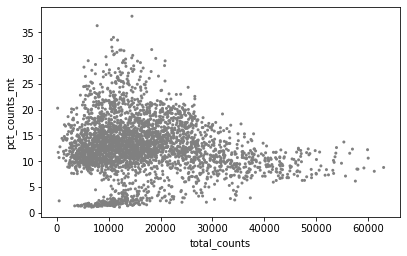

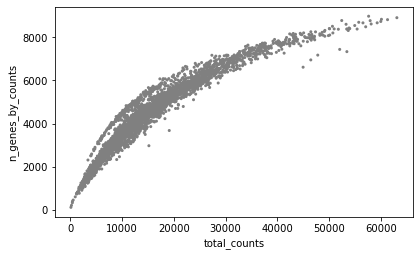

In [19]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [20]:
len1=adata.shape
adata=adata[adata.obs["n_genes_by_counts"]<8000 ,:]
adata=adata[adata.obs["n_genes_by_counts"]>1000, :] 
adata=adata[adata.obs["total_counts"]<50000, :]
adata=adata[adata.obs["pct_counts_mt"]<30, :]
len2=adata.shape
print("Filter out",len1[0]-len2[0],"cells because of the outlier QC metrics, with",len2[0],"cells left.")

Filter out 96 cells because of the outlier QC metrics, with 3193 cells left.


<a id='n'></a>
### 3.1.2 Normalization

<p>The variance of molecular counts expresses spatial heterogeneity which cannot be solely explained by technical noise. we recommends normalization using normalize_total in order to account for technical bias while preserving true biological differences.</p>

TypeError: __init__() got an unexpected keyword argument 'location'

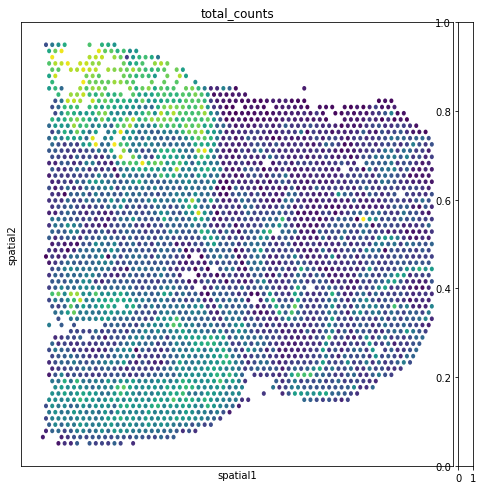

In [21]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts","pct_counts_mt"])

In [22]:
sc.pp.normalize_total(adata,inplace=True)

sc.pp.log1p(adata)


sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)


C:\Users\AL-FAJR\anaconda3\lib\site-packages\scanpy\preprocessing\_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


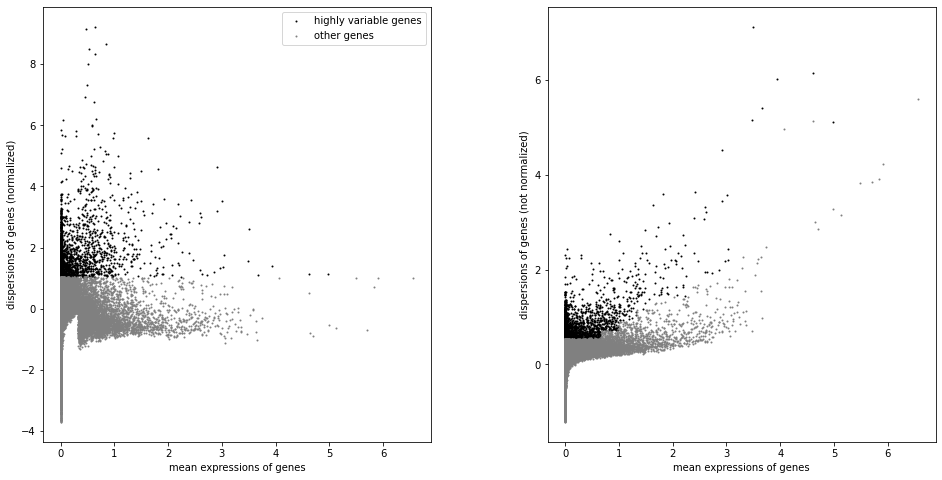

In [23]:
sc.pl.highly_variable_genes(adata)

In [31]:
###show some highly_variable genes

In [32]:
data_set= adata[:,adata.var["highly_variable"]==True]
data_set.var_names[0:5]


Index(['St18', 'Vxn', 'Sgk3', 'Sulf1', 'Slco5a1'], dtype='object')

<a id='dt'></a>
## 3.2 Downstream tasks (dimension reduction, data visualization, cluster annotation, differential expression)

In [35]:
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata, key_added="clusters")

In [ ]:
plt.rcParams["figure.figsize"] = (4, 4)
sc.pl.umap(adata, color=["total_counts", "n_genes_by_counts", "clusters"], wspace=0.4)

#### find marker genes
Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the .raw attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.

categories: 0, 1, 2, etc.
var_group_labels: 5


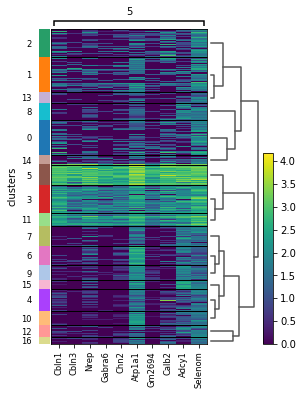

In [37]:
#found cluster marker_genes
sc.tl.rank_genes_groups(adata, "clusters", method="t-test")
sc.pl.rank_genes_groups_heatmap(adata, groups="5", n_genes=10, groupby="clusters")

In [42]:
result = adata.uns['rank_genes_groups']
groups = result['names'].dtype.names
df=pd.DataFrame(
    {group + '_' + key: result[key][group]
    for group in groups for key in ['names', 'pvals','pvals_adj','logfoldchanges']}).head(5)
df=df.iloc[:,20:24]
df

,5_names,5_pvals,5_pvals_adj,5_logfoldchanges
0,Cbln1,3.913000e-321,1.263312e-316,4.353279
1,Cbln3,4.392604e-228,3.545381e-224,5.140144
2,Nrep,7.782450e-231,8.375213e-227,4.017993
3,Gabra6,4.464932e-194,1.601670e-190,4.942911
4,Chn2,3.640194e-203,1.469046e-199,3.920192


expression of some genes  in cluster

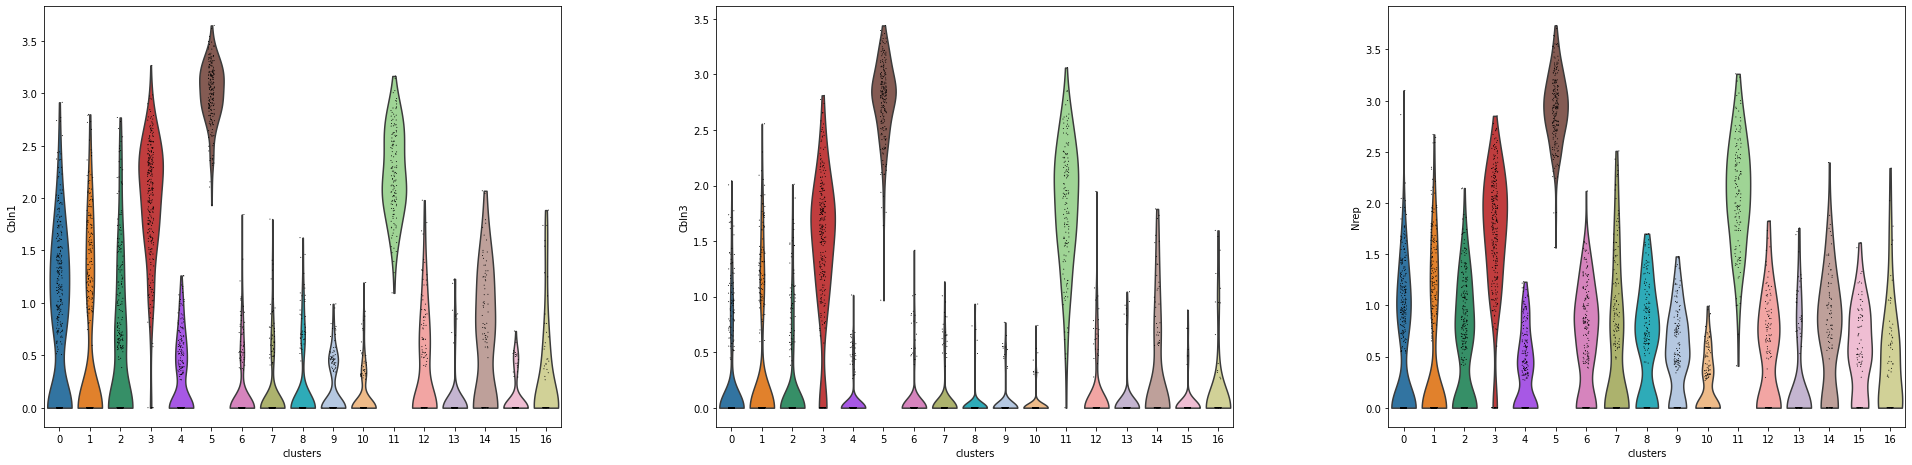

In [41]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.violin(adata, ["Cbln1","Cbln3","Nrep"], groupby='clusters')

<p>We see that cbln1  recapitulates the spatial structure.</p>

In [ ]:
sc.pl.spatial(adata, img_key="hires", color=["clusters", "cbln1"])

<a id='vsc'></a>
##  3.3 Visualization in spatial coordinates

<p>now take a look at how total_counts and n_genes_by_counts behave in spatial coordinates. We will overlay the circular spots on top of the Hematoxylin and eosin stain (H&E) image provided, using the function sc.pl.spatial.</p>

In [ ]:
plt.rcParams["figure.figsize"] = (8, 8)
sc.pl.spatial(adata, img_key="hires", color=["total_counts", "n_genes_by_counts"])

<p>Before, we performed clustering in gene expression space, and visualized the results with UMAP. By visualizing clustered samples in spatial dimensions, we can gain insights into tissue organization and, potentially, into inter-cellular communication.</p>

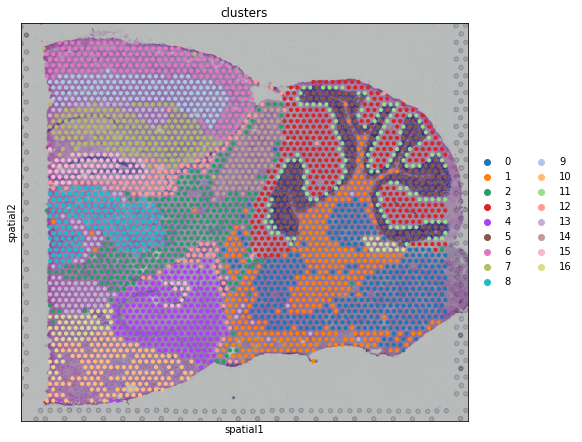

In [45]:
sc.pl.spatial(adata, img_key="hires", color="clusters", size=1)

## Image features

<p>now in this block we calculate image features for each Visium spot and create a obs x features matrix in adata that can then be analyzed together with the obs x gene gene expression matrix using function  calculate_image_features()</p>

In [ ]:
img=sq.im.ImageContainer.from_adata(adata, img_key=None, library_id=None, spatial_key='spatial')

# calculate features for different scales (higher value means more context)
for scale in [1.0, 2.0]:
    feature_name = f"features_summary_scale{scale}"
    sq.im.calculate_image_features(
        adata,
        img.compute(),
        features="summary",
        key_added=feature_name,
        n_jobs=4,
        scale=scale,
    )


# combine features in one dataframe
adata.obsm["features"] = pd.concat(
    [adata.obsm[f] for f in adata.obsm.keys() if "features_summary" in f], axis="columns"
)
# make sure that we have no duplicated feature names in the combined table

adata.obsm["features"].columns = ad.utils.make_index_unique(adata.obsm["features"].columns)


<p>We can use the extracted image features to compute a new cluster annotation. This could be useful to gain insights in similarities across spots based on image morphology.<p>
<ul>
<li>cluster_features()  is a function that takes a features extracted from the image as a data frame and returns a leiden based cluster</li>
<li>the features are filtered using the ‘like’ clause that filters the data based on a given string i.e. “summary”.</li>
    <li>The filtered features are then get clustring using scale(),pca() and neighbor() functions  and clustered using leiden clustering function.</li>
<li>Lastly, we compare the features cluster with the gene cluster using spatial plotting.</li>
    </ul>


In [ ]:
# helper function returning a clustering
def cluster_features(features: pd.DataFrame, like=None) -> pd.Series:
    """
    Calculate leiden clustering of features.

    Specify filter of features using `like`.
    """
    # filter features
    if like is not None:
        features = features.filter(like=like)
    # create temporary adata to calculate the clustering
    adata = ad.AnnData(features)
    # important - feature values are not scaled, so need to scale them before PCA
    sc.pp.scale(adata)
    # calculate leiden clustering
    sc.pp.pca(adata, n_comps=min(10, features.shape[1] - 1))
    sc.pp.neighbors(adata)
    sc.tl.leiden(adata)

    return adata.obs["leiden"]


# calculate feature clusters
adata.obs["features_cluster"] = cluster_features(adata.obsm["features"], like="summary")

# compare feature and gene clusters
sc.set_figure_params(facecolor="white", figsize=(8, 8))
sc.pl.spatial(adata, color=["features_cluster", "clusters"])

<a id='ss'></a>
## 3.4 Spatial statistics and graph analysis

<p>we can investigate spatial organization by leveraging spatial and graph statistics in Visium data.</p>

<a id='ne'></a>
### 3.4.1 Neighborhood enrichment

<p>Computing a neighborhood enrichment can help us identify spots clusters that share a common neighborhood structure across the tissue. We can compute such score with the following function: squidpy.gr.nhood_enrichment(). In short, it’s an enrichment score on spatial proximity of clusters: if spots belonging to two different clusters are often close to each other, then they will have a high score and can be defined as being enriched. On the other hand, if they are far apart, and therefore are seldom a neighborhood, the score will be low and they can be defined as depleted. This score is based on a permutation-based test,Since the function works on a connectivity matrix, we need to compute that as well. This can be done with squidpy.gr.spatial_neighbors().</p>

  0%|          | 0/1000 [00:00<?, ?/s]

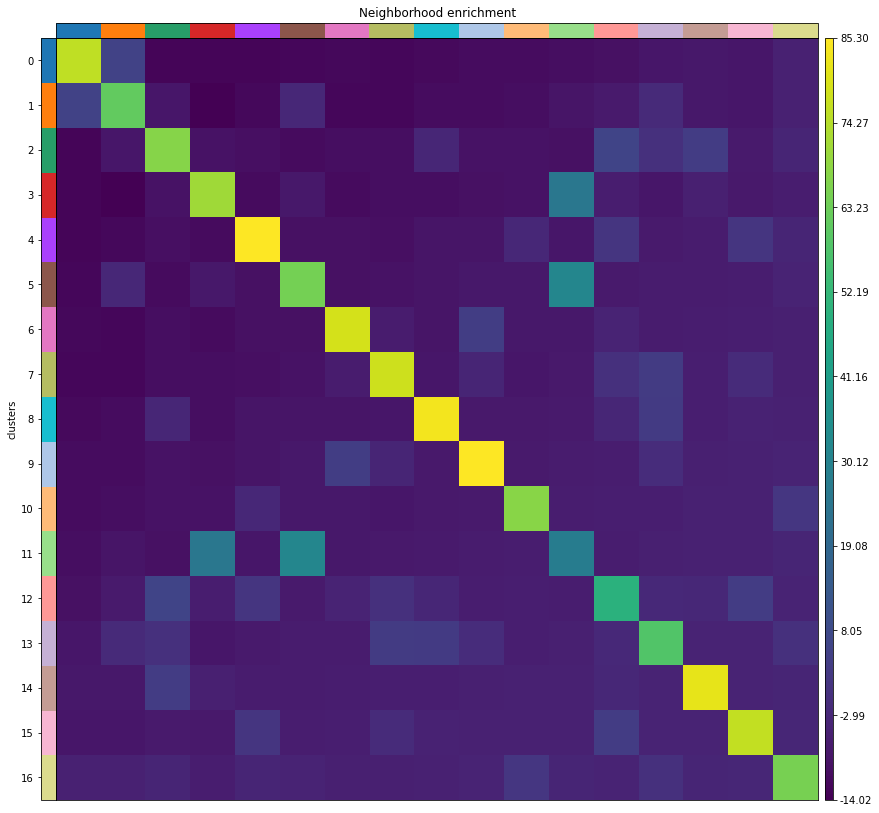

In [43]:
sq.gr.spatial_neighbors(adata)
sq.gr.nhood_enrichment(adata, cluster_key="clusters")
sq.pl.nhood_enrichment(adata, cluster_key="clusters")

<a id='csd'></a>
### 3.4.2 Co-occurrence across spatial dimensions

<p>we can visualize cluster co-occurrence in spatial dimensions. This is a similar analysis of the one presented above, yet it does not operate on the connectivity matrix, but on the original spatial coordinates , where p(exp/cond)  is the conditional probability of observing a cluster(exp)  conditioned on the presence of a cluster (cond) , whereas P(exp) is the probability of observing  in the radius size of interest. The score is computed across increasing radii size around each observation (i.e. spots here) in the tissue.</p>

<img src="html.PNG" width="500" height="333">

  0%|          | 0/1 [00:00<?, ?/s]

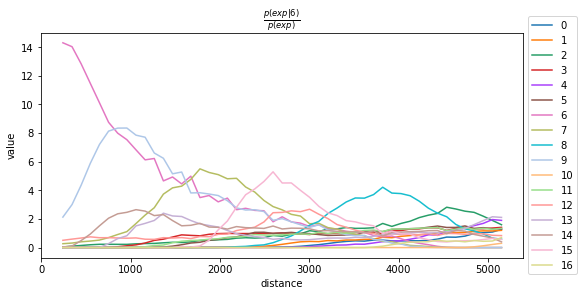

In [44]:
sq.gr.co_occurrence(adata, cluster_key="clusters")
sq.pl.co_occurrence(
    adata,
    cluster_key="clusters",
    clusters="6",
    figsize=(8, 4),
)

<a id='lra'></a>
### 3.4.3 Ligand-receptor interaction analysis

Now we provide a fast re-implementation the popular method CellPhoneDB  and extended its database of annotated ligand-receptor interaction pairs with the popular database Omnipath  . we run the analysis for all clusters pairs, and all genes  using function  squidpy.gr.ligrec(). then we visualize the results, filtering out lowly-expressed genes (with the means_range argument) and increasing the threshold for the adjusted p-value (with the alpha argument).

In [ ]:
sq.gr.ligrec(
    adata,
    n_perms=100,
    cluster_key="clusters",
    use_raw=False
)


In [ ]:
sq.pl.ligrec(
    adata,
    cluster_key="clusters",
    source_groups="2",
    target_groups=["6", "7"],
    means_range=(3, np.inf),
    alpha=1e-4,
    swap_axes=True,
)

<a id='isv'></a>
## 3.5 Identify spatially variable genes


Anndata is able to calculate two metrics in order for the users to identify spatially variable genes, namely Moran’s I statistic Spatial coordinates of the cells are incorporated to identify features with spatial heterogeneity in its expression.

<a id='m'></a>
### 3.5.1 Moran’s I

Moran’s I is a global metric measuring the correlation of gene expression values between local observed values and the average of neighboring values. We can interpret Moran’s I as a spatial autocorrelation metric similar to the Pearson correlation coefficient in the context of spatial statistics. We can either calculate the z-score under normality assumption or perform permutation test to see whether we can reject the null hypothesis of zero spatial autocorrelation.


<img src="html2.PNG" width="500" height="333">


In [50]:
genes = adata[:, adata.var.highly_variable].var_names.values[:2000]
sq.gr.spatial_autocorr(
    adata,
    mode="moran",
    genes=genes,
    n_perms=100,
    n_jobs=1,
)

  0%|          | 0/100 [00:00<?, ?/s]

### Top 3 genes with the largest Moran's I

In [51]:
adata.uns["moranI"].head()

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Nrgn,0.876388,0.0,0.000112,0.0,0.009901,0.000303,0.0,0.0,0.016311
Pcp2,0.860199,0.0,0.000112,0.0,0.009901,0.000257,0.0,0.0,0.016311
Ttr,0.849436,0.0,0.000112,0.0,0.009901,0.000309,0.0,0.0,0.016311
Fth1,0.843086,0.0,0.000112,0.0,0.009901,0.000238,0.0,0.0,0.016311
Mobp,0.817920,0.0,0.000112,0.0,0.009901,0.000302,0.0,0.0,0.016311


In [ ]:
sc.pl.spatial(adata, color=["Nrgn", "Pcp2", "Ttr", "cluster"])

### Bottom 3 genes with the smallest Moran's I

In [52]:
adata.uns["moranI"].tail(5)

,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Gm11423,-0.012276,0.128829,0.000112,0.043170,0.049505,0.000048,0.197288,0.066160,0.075178
Pim1,-0.013122,0.112746,0.000112,0.040975,0.029703,0.000055,0.173608,0.062942,0.046593
1700123M08Rik,-0.013127,0.112666,0.000112,0.039125,0.019802,0.000048,0.173608,0.060146,0.031633
Gm26910,-0.015599,0.074028,0.000112,0.010332,0.009901,0.000045,0.116671,0.016518,0.016311
Mcm3,-0.015838,0.070907,0.000112,0.010675,0.029703,0.000055,0.112107,0.017026,0.046593


In [ ]:
sc.pl.spatial(adata, color=["Mcm3", "Gm26910", "Pim1", "cluster"])